# Libraries

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
import pickle
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from datetime import datetime, timedelta

# Keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import LSTM, GRU

# Sklearn
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_percentage_error

# Funtions

In [4]:
def predict(num_prediction, model): #funzione per la previsione ricorsiva delle RNN
    prediction_list = dataset[-look_back:]
    
    for _ in range(num_prediction):
        x = prediction_list[-look_back:]
        x = x.reshape((1, 1, look_back)) 
        out = model.predict(x)[0][0]
        prediction_list = np.append(prediction_list, out)
    prediction_list = prediction_list[look_back-1:]
        
    return prediction_list

In [5]:
def create_dataset(dataset, look_back=1): #funzione per ristrutturare il dataset per le RNN
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return np.array(dataX), np.array(dataY)

In [6]:
def MAPE(Y_actual,Y_Predicted):
    mape = np.mean(np.abs((Y_actual - Y_Predicted)/Y_actual))*100
    return mape

In [7]:
def divisione(train, test, look_back = 1):
  trainX, trainY = create_dataset(train, look_back)
  testX, testY = create_dataset(test, look_back)

  #Ristrutturazione del dataset
  trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
  testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
  
  return trainX, trainY, testX, testY

In [ ]:
def lstm(train, test, look_back = 24, neurones = 4, epochs = 10, batch_size = 256):

  trainX, trainY, testX, testY = divisione(train, test, look_back)

  model = Sequential()
  model.add(LSTM(neurones, input_shape=(1, look_back)))
  model.add(Dense(1))
  model.compile(loss='mean_squared_error', optimizer='adam')
  model.fit(trainX, trainY, epochs=epochs, batch_size=batch_size, verbose = 0)

  num_pred = len(testY)-1
  
  #Previsioni 
  trainPredict = model.predict(trainX)
  testPredict = predict(num_pred, model)
  #Previsioni scalate
  trainPredict = scaler.inverse_transform(trainPredict)
  trainY = scaler.inverse_transform([trainY])
  testPredict = scaler.inverse_transform(testPredict.reshape(-1,1))
  testY = scaler.inverse_transform([testY])

  print('LookBack:',look_back)
  #Calcolo MAPE
  trainScore = MAPE(trainY[0], trainPredict[:,0])
  print('Train Score: %.2f MAPE' % (trainScore))
  testScore = MAPE(testY[0], testPredict[:,0])
  print('Test Score: %.2f MAPE' % (testScore))
  return trainPredict, testPredict

In [ ]:
def gru(train, test, look_back = 24, neurones = 4, epochs = 10, batch_size = 256):

  trainX, trainY, testX, testY = divisione(train, test, look_back)

  model = Sequential()
  model.add(GRU(neurones, input_shape=(1, look_back)))
  model.add(Dense(1))
  model.compile(loss='mean_squared_error', optimizer='adam')
  model.fit(trainX, trainY, epochs=epochs, batch_size=batch_size, verbose = 0)

  num_pred = len(testY)-1
  
  #Previsioni 
  trainPredict = model.predict(trainX)
  testPredict = predict(num_pred, model)
  #Previsioni scalate
  trainPredict = scaler.inverse_transform(trainPredict)
  trainY = scaler.inverse_transform([trainY])
  testPredict = scaler.inverse_transform(testPredict.reshape(-1,1))
  testY = scaler.inverse_transform([testY])

  print('LookBack:',look_back)
  #Calcolo MAPE
  trainScore = MAPE(trainY[0], trainPredict[:,0])
  print('Train Score: %.2f MAPE' % (trainScore))
  testScore = MAPE(testY[0], testPredict[:,0])
  print('Test Score: %.2f MAPE' % (testScore))
  return trainPredict, testPredict

# Import data

Caricamento dei dati

In [10]:
data = pd.read_csv('/content/gdrive/MyDrive/ts_dataset_noNA.csv')
data['Valore'] = data['CO']
data['Datetime'] = pd.to_datetime(data['Date']) + pd.to_timedelta(data['Hour'], unit='h')
ts = data[['Datetime','Valore']].set_index('Datetime')
ts = pd.DataFrame(ts)
ts

,Valore
Datetime,
2004-03-10 18:00:00,1360.0
2004-03-10 19:00:00,1292.0
2004-03-10 20:00:00,1402.0
2004-03-10 21:00:00,1376.0
2004-03-10 22:00:00,1272.0
...,...
2005-02-28 19:00:00,938.0
2005-02-28 20:00:00,939.0
2005-02-28 21:00:00,827.0


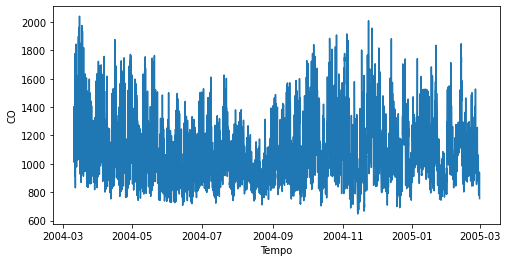

In [11]:
plt.figure(figsize=(8,4))
plt.xlabel('Tempo')
plt.ylabel('CO')
plt.plot(ts)

# Train-Test

In [12]:
# Train - Test
limit = int(len(ts)*0.8)   # 6820
train, test = ts[0:limit], ts[limit:len(ts)]

#Normalizzazione del dataset
scaler = MinMaxScaler(feature_range=(0, 1))
train_norm = scaler.fit_transform(train)
test_norm = scaler.transform(test)

dataset = np.concatenate((train_norm, test_norm))

# RNN

In [ ]:
lb = [24, 24*7,
      24*7*2, 24*7*4]

epoch = 20
neurones = 512

count = 0
for look_back in lb:
  count +=1
  print('Modello',count,'su',len(lb))
  trainPredict, testPredict = lstm(train = train_norm, 
                                   test = test_norm,
                                   look_back = look_back,
                                   neurones = neurones,
                                   epochs = epoch,
                                   batch_size = 256)
  print()

# GRU

In [ ]:
lb = [24, 24*7,
      24*7*2, 24*7*4]

epoch = 20
neurones = 512

count = 0
for look_back in lb:
  count +=1
  print('Modello',count,'su',len(lb))
  trainPredict, testPredict = gru(train = train_norm,
                                  test = test_norm,
                                  look_back = look_back,
                                  neurones = neurones,
                                  epochs = epoch,
                                  batch_size = 256)
  print()

# Previsioni

In [ ]:
test_datetime = pd.date_range(start='2005-03-01', end='2005-04-01', freq ='H')[0:-1]

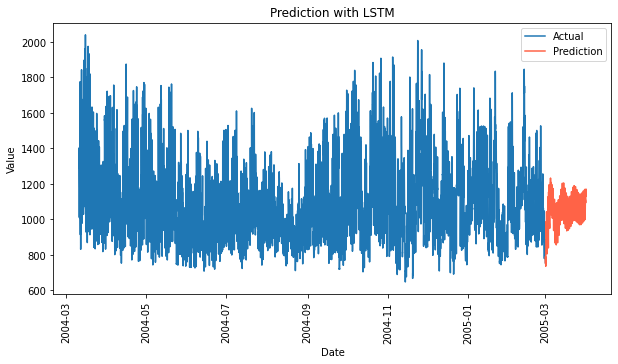

In [ ]:
scaler = MinMaxScaler(feature_range=(0, 1))
dataset_def = scaler.fit_transform(ts)

train_def = dataset_def

look_back = 24*7

trainX, trainY = create_dataset(train_def, look_back)
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))

model = Sequential()
model.add(LSTM(512, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=20, batch_size=256, verbose=0)

test_datetime = pd.date_range(start='2005-03-01', end='2005-04-01', freq ='H')[0:-1]
num_prediction = len(test_datetime)
forecast = predict(num_prediction, model)

forecast = scaler.inverse_transform(forecast.reshape(-1,1)).flatten()
forecast = pd.DataFrame(forecast[0:31*24], index = test_datetime)

fig=plt.figure(figsize=(10,5))
fig.show()
ax=fig.add_subplot(111)


plt.title('Prediction with LSTM')
plt.xlabel('Date')
plt.ylabel('Value')
plt.xticks(rotation=90)
ax.plot(ts, label='Actual')
ax.plot(forecast, color='tomato', label='Prediction')
plt.legend()
plt.show()

In [ ]:
forecast.to_csv('/content/gdrive/MyDrive/risultati_ml_3_1.csv',
                sep = ',')

# File

In [14]:
res_arima_ucm = pd.read_csv('/content/gdrive/MyDrive/pred_arima_ucm.csv')
risultati_top = pd.read_csv('/content/gdrive/MyDrive/risultati_ml_3_1.csv',
                            sep = ',')
risultati_top['Datetime'] = pd.to_datetime(risultati_top['Unnamed: 0'])
risultati_top['Valore'] = risultati_top['0']
res = risultati_top[['Datetime','Valore']].set_index('Datetime')
res = pd.DataFrame(res)

res.rename(columns={"Valore": "ML"}, inplace = True)
res['Hour'] = res.index.hour
res['Hour'] = res['Hour'].replace(0,24)
res['Date'] = res.index.date
res.reset_index(drop = True, inplace = True)
res['ARIMA'] = res_arima_ucm['ARIMA']
res['UCM'] = res_arima_ucm['UCM']

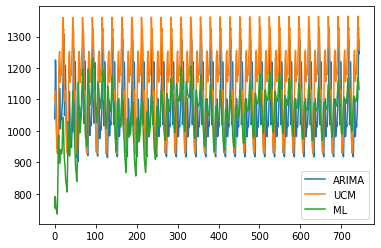

In [15]:
plt.plot(res['ARIMA'], label = 'ARIMA')
plt.plot(res['UCM'], label = 'UCM')
plt.plot(res['ML'], label = 'ML')
plt.legend()
plt.show()

In [ ]:
res.to_csv('/content/gdrive/MyDrive/830697_20220204.csv',
           columns = ['Date','Hour','ARIMA','UCM','ML'],
           index = False)